In [1]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
# import cv2
import skimage as sk
from sympy import Ellipse, Point

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Filename: /home/bruce/Documents/imagenesMicrochip/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_25.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 400)   float32   
  1                1 ImageHDU       164   (700, 400)   float32   
  2                1 ImageHDU       164   (700, 400)   float32   
  3                1 ImageHDU       164   (700, 400)   float32   


None
----------------


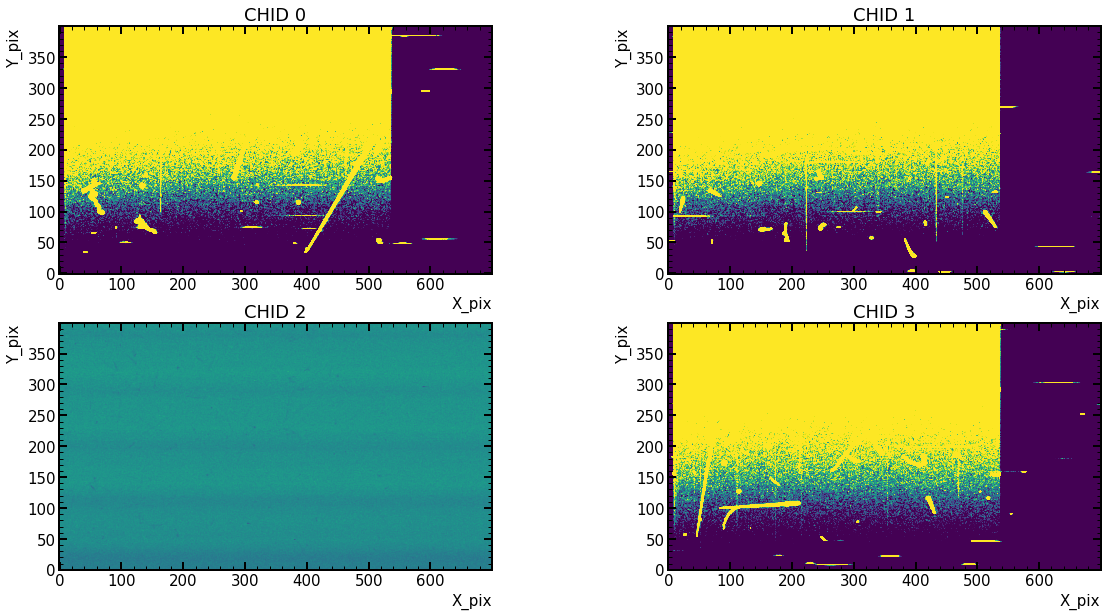

In [48]:
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_324_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/17OCT23/am241_gammas/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_50_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_690.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_225_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_144_NROW_100_NCOL.fits'

## DIRECCIONES DE COMPUTADORA DE CASA 
path = '/home/bruce/Documents/imagenesMicrochip/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_25.fits'

hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=-800,vmax=800)
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

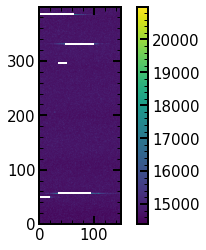

In [81]:
extension = 1
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
Overscan = hdu_list[extension - 1].data[:, 550:]
oScan_mask=sk.measure.label(Overscan>=21000, connectivity=2)
oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
plt.imshow(oScan, origin='lower')
plt.colorbar()

14


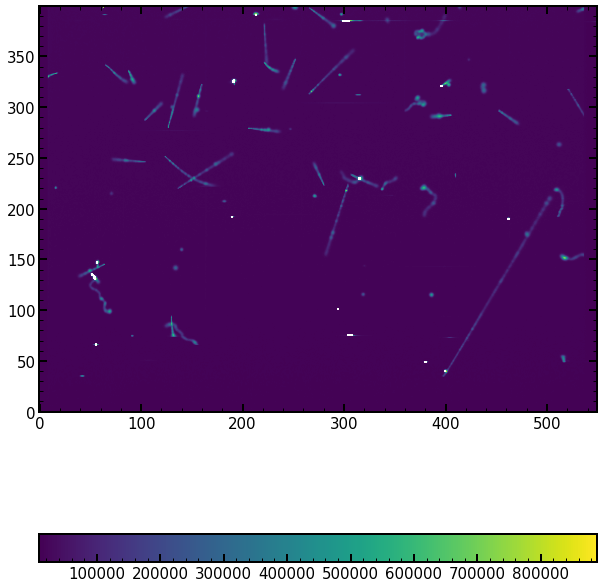

In [89]:
plt.figure(figsize=[10,15])
active_area = hdu_list[extension - 1].data[:, :550]
active_area_mask=sk.measure.label(active_area>=900000, connectivity=2)
active_area_true=ma.masked_array(active_area,mask=(active_area_mask>0))
plt.imshow(active_area_true, origin='lower')
plt.colorbar(location = 'bottom')
# plt.colorbar()

print(active_area_mask.max())

Offset:  14386.269


Centroide:  0.05694127247535826  Amplitud:  97824.84079759268 sigma:  0.04291308193741557


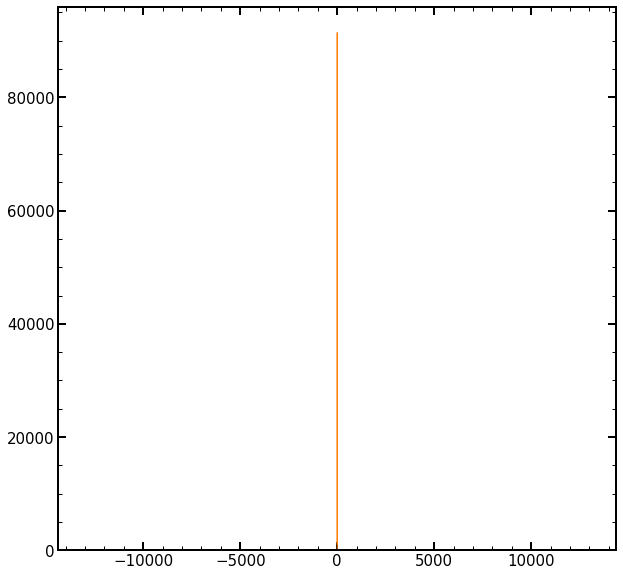

In [95]:
# extension = 4
Bins = 1000
ratio_keV = 0.0037

# data = hdu_list[extension-1].data[:, :550]
data = active_area
header=hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

nsamp=float(header['NSAMP'])
# expgain = [227, 220.4, 94.72, 197.7]
expgain = [227, 220.4, 94.72, 200] ## e-/ADUs

#Aplanar la imágen
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))
hist , bins_edges = np.histogram(oScan.flatten(), bins = Bins)
offset = bins_edges[np.argmax(hist)]
print('Offset: ', offset)

# data = 
dataP = data-offset
dataCal = (ratio_keV * dataP)/expgain[extension-1] ## En keV
# dataCal = dataP

bin_heights, bin_borders, _ = axs_all.hist(dataCal.flatten(), bins= Bins)#, log=True)#,  range=[-200000, 1000000])
bin_centers=np.zeros(len(bin_heights), dtype=float)
offset_fit = bin_borders[np.argmax(bin_heights)]
for p in range(len(bin_heights)):
    bin_centers[p]=(bin_borders[p+1]+bin_borders[p])/2

# xmin_fit, xmax_fit = offset_fit-(10*expgain[extension-1])/math.sqrt(nsamp), offset_fit+(10*expgain[extension-1])/math.sqrt(nsamp)			# Define fit range
xmin_fit, xmax_fit = -abs(offset), abs(offset)

bin_heights = bin_heights[(bin_centers>xmin_fit) & (bin_centers<xmax_fit)]
bin_centers = bin_centers[(bin_centers>xmin_fit) & (bin_centers<xmax_fit)]

popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, maxfev=10000, p0 = [1,1,10])		# Fit histogram with gaussian
axs_all.plot(bin_centers, gaussian(bin_centers, *popt))	
plt.xlim(-offset, offset)


# plt.xlim(-50,50)
# plt.ylim(0, 100)
# axs_all.set_yscale('log')
# plt.show()

print('Centroide: ',popt[1], ' Amplitud: ', popt[0], 'sigma: ', popt[2]) #gaussian(x, a, mean, sigma)
# n_events
# print(popt)
# dataP
# print(header['RUNID'])

In [96]:
list_Runid = []
list_ext = []
list_Matrix_Slice_Event = []
list_Size_Matrix_Event = []
#Listas a mano
list_event_size = []
list_charge = []
list_mean_charge = []
list_Barycenter= []
list_Barycenter_charge = []
list_n_events = []

#Listas skmeasure
list_event_size_sk = []
list_mean_charge_sk = []
list_Barycenter_sk= []
list_Barycenter_charge_sk = []
list_n_events_sk = []

# extension = extension ## Extension's number
extra = 0
# data = hdu_list[extension-1].data
header = hdu_list[extension-1].header
Runid = str(int(header['RUNID']))

oScan=hdu_list[extension-1].data[:,530:]
expgain = [227, 220.4, 94.72, 197.7]

hist , bins_edges = np.histogram(oScan.flatten(), bins = 1000000)
offset = bins_edges[np.argmax(hist)]
dataP = data-offset ## Datos aplanados
# dataCal = (ratio_keV * dataP)/expgain[extension-1] ## Datos normalizados en keV

min_energy_for_label = 6 * abs(popt[2])
# label, n_events =ndimage.label(dataCal>6*abs(popt[2]),structure=[[1,1,1],[1,1,1],[1,1,1]])
# label, n_events =ndimage.label(dataCal>6*abs(popt[2]),structure=[[1,0,1],[1,1,1],[1,0,1]])
# label, n_events =ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]])
label_img, nlabels_img = sk.measure.label(dataCal> min_energy_for_label, connectivity=2, return_num=True)

prop = sk.measure.regionprops(label_img,dataCal)

## Obteniendo el valor promedio del fondo
# fondo_mask = np.invert(label==0)
fondo_mask = np.invert(label_img==0)
fondo = ma.masked_array(dataCal,fondo_mask)
# print(fondo)
valor_promedio_fondo = fondo.data.mean()
# print(valor_promedio_fondo)
# plt.imshow(fondo, cmap='gray')
# plt.colorbar()


for i in range(0,nlabels_img):
    list_n_events.append(i+1)

for event in range(1, nlabels_img+1):
    mask = np.invert(label_img == event)
    loc = ndimage.find_objects(label_img == event)[0]
    
    data_maskEvent = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop],
                                         mask[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    if len(data_maskEvent)<1:
        list_Size_Matrix_Event.append('NaN')

    else:
        ## Número de imagen
        list_Runid.append(Runid)

        ## Número de Extensión
        list_ext.append(extension)

        ## Lista de Coordenadas de cada evento
        list_Size_Matrix_Event.append(str(data_maskEvent.shape[1])+'x'+str(data_maskEvent.shape[0])) ## La dimensión de la matriz del evento en pixeles
        
        event_size = 0
        # Obtiene los pixeles que componen al evento(a mano)
        # for i in range(0,len(data_maskEvent.flatten())):
        #     if data_maskEvent.flatten()[i]:
        #         event_size = event_size+1
        # list_event_size.append(int(event_size))

        # Obtiene los pixeles que componen al evento(con skmeasure)
        # try:
        num_pixels = prop[event-1].num_pixels
        list_event_size_sk.append(num_pixels)
        # except:
        #     list_event_size_sk.append('NaN')

        # Obtiene la carga total del evento en electrones
        # charge = 0
        # for i in data_maskEvent.data.flatten():
        #     if i >= valor_promedio_fondo:
        #         charge = charge + i
        charge = data_maskEvent.sum()
        # list_charge.append(data_maskEvent.sum())
        list_charge.append(charge)

        # Carga promedio en electrones (a mano)
        # try:
        #     mean_charge = charge/event_size
        #     list_mean_charge.append(round(mean_charge,3))
        # except:
        #     # list_mean_charge.append('None Event Size')
        #     continue

        mean_ch = prop[event-1].intensity_mean
        list_mean_charge_sk.append(round(mean_ch,3))
        

        ## Baricentro (a mano)
        # centerCharge = ndimage.center_of_mass(data[1][loc])
        # coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1],4)
        # coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0],4)
        # list_coordCenterCharge = [coordX_centerCharge, coordY_centerCharge]
        # list_Barycenter.append(list_coordCenterCharge)
        # print(centerMass)

        ## Baricentro (con skmeasure)
        coordY_centerCharge, coordX_centerCharge = round(prop[event-1].centroid_local[0],4), round(prop[event-1].centroid_local[1],4)
        list_coordCenterCharge = [coordX_centerCharge, coordY_centerCharge]
        # print('Barycenter: ', prop[n_label-1].centroid_local)
        list_Barycenter_sk.append(list_coordCenterCharge)
        # print(centerMass)


        ## Carga del Baricentro (a mano)
        # coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
        # coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])
        # BarycenterChage = data_maskEvent[coordY_centerCharge, coordX_centerCharge]
        
        # if BarycenterChage:
        #     list_Barycenter_charge.append(BarycenterChage)
        # else: 
        #     list_Barycenter_charge.append('NaN')

        ## Carga del Baricentro (con skmeasure)
        BarycenterChage = prop[event-1].centroid_weighted_local
        # if BarycenterChage:
        list_Barycenter_charge_sk.append(BarycenterChage)
        # else: 
        #     list_Barycenter_charge_sk.append('NaN')
        # list_centerCharge.append(centerCharge)
        # print(list_centerCharge)

## DataFrame de Cada evento
print('Events: '+ str(list_n_events[-1]))
RunidFrame = pd.DataFrame(list_Runid, columns = ['Image ID'])
ExtensionFrame = pd.DataFrame(list_ext, columns = ['Extension'])
Event_IDFrame= pd.DataFrame(list_n_events, columns = ['Event ID'])
Matrix_Size_EventFrame = pd.DataFrame(list_Size_Matrix_Event, columns = ['Matrix Size (px)'])

# Event_SizeFrame = pd.DataFrame(list_event_size, columns = ['Event Size (px)'])
EventSK_SizeFrame = pd.DataFrame(list_event_size_sk, columns = ['Event Size SK (px)'])

ChargeFrame = pd.DataFrame(list_charge, columns = ['Total Charge (keV)'])

# MeanChargeFrame = pd.DataFrame(list_mean_charge, columns = ['Mean Charge (keV)'])
MeanChargeSKFrame = pd.DataFrame(list_mean_charge_sk, columns = ['Mean Charge SK (keV)'])


# totalFrame =pd.concat([Event_IDFrame,RunidFrame, ExtensionFrame, Matrix_Size_EventFrame, Event_SizeFrame, EventSK_SizeFrame, ChargeFrame, MeanChargeFrame, MeanChargeSKFrame], axis = 1 )
totalFrame = pd.concat([Event_IDFrame, RunidFrame, ExtensionFrame, Matrix_Size_EventFrame, EventSK_SizeFrame, ChargeFrame, MeanChargeSKFrame], axis = 1 )

# totalFrame['Barycenter (px)']=pd.Series(list_Barycenter)
totalFrame['Barycenter_SK (px)']=pd.Series(list_Barycenter_sk)

# totalFrame["Barycenter Charge (keV)"]=pd.Series(list_Barycenter_charge)
# totalFrame["Barycenter Charge SK (e-)"]=pd.Series(list_Barycenter_charge_sk)


TF = totalFrame.set_index('Event ID')
TF
# TF.query('Event Size (px) >= 200')
# totalFrame.style.hide_index()

Events: 84


,Image ID,Extension,Matrix Size (px),Event Size SK (px),Total Charge (keV),Mean Charge SK (keV),Barycenter_SK (px)
Event ID,,,,,,,
1,25,1,5x1,5,32.183731,6.437,"[2.0, 0.0]"
2,25,1,110x179,810,1029.383667,1.271,"[61.8753, 100.5494]"
3,25,1,5x1,5,103.474915,20.695,"[2.0, 0.0]"
4,25,1,9x8,47,118.781891,2.527,"[3.8298, 3.5106]"
5,25,1,4x1,4,2.129069,0.532,"[1.5, 0.0]"
...,...,...,...,...,...,...,...
80,25,1,10x8,48,84.023300,1.750,"[4.7917, 3.2708]"
81,25,1,1x1,1,0.291400,0.291,"[0.0, 0.0]"
82,25,1,8x5,36,95.866409,2.663,"[3.6667, 2.1944]"


Event Slice:
x: [544,550]
y: [384,385]


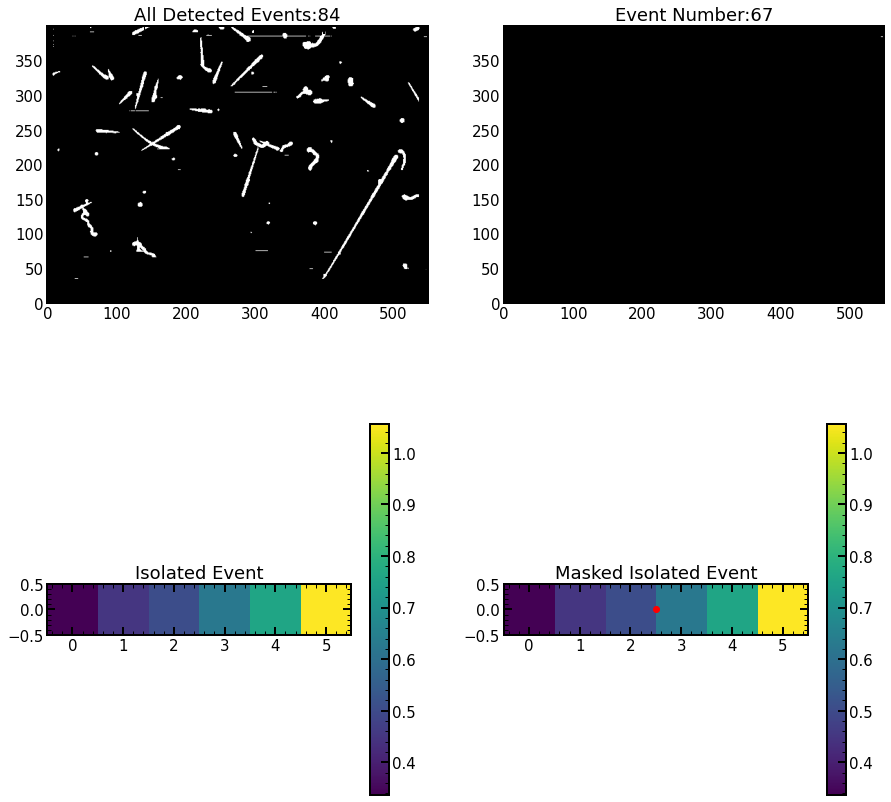

,Image ID,Extension,Matrix Size (px),Event Size SK (px),Total Charge (keV),Mean Charge SK (keV),Barycenter_SK (px)
Event ID,,,,,,,
67,25,1,6x1,6,3.73394,0.622,"[2.5, 0.0]"


In [97]:
n_label = 67
extra = 0
label, n_events =ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52

loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1,vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[0,1].set_title('Event Number:'+str(n_label))
axs[0,1].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[1,0].set_title('Isolated Event')
x1 = axs[1,0].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap='viridis', origin = 'lower')
# plt.colorbar()

mask_35 = np.invert(label==n_label)
data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap='viridis', origin='lower')
axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[1,0])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()
totalFrame.set_index('Event ID').iloc[[n_label-1]]

Centroide:  (49.0, 381.0)
Radio mayor:  5.656854249492381
Radio menor:  0.0
Box:  (49, 379, 50, 384)
Centroid Weighted:  (49.0, 380.5871376907934)
Label:  3
Orientation:  1.5707963267948966
Slice:  (slice(49, 50, None), slice(379, 384, None))
Eccentricity:  1.0
Solidity:  1.0
Barycenter:  [0. 2.]


Event Charge:  103.474915  keV
Local Box:  [5, 1]  px
Local Box:  [75, 15] micras
Diagonal Lenght:  3.6848059512196896  px
Diagonal Lenght:  55.272089268295346  micras
Delta_L:  725.0093639360102  px
Delta_L:  10875.140459040154  micras
Delta EL:  0.14272217670269155  keV/px
Delta EL:  0.009514811780179436  keV/micras
Delta EL:  1427.2217670269154  keV/cm


(378.0, 385.0, 48.0, 51.0)

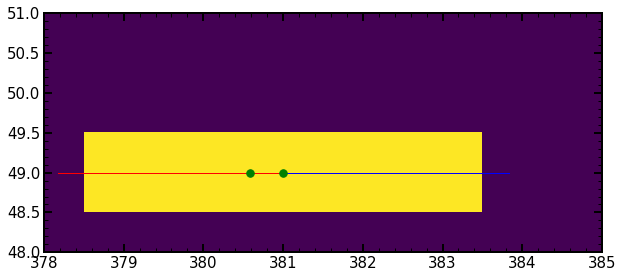

In [98]:
n_label= 3
CCD_depth = 725 ## micras
px_to_micras = 15 ## micras
px_to_cm = 0.0015 ## cm/px
micra_to_cm = 1 / 10000 ## micras/cm
fig, ax = plt.subplots(figsize=(10,10))

label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
# print(nlabels_img)
ax.imshow(label_img==n_label) # Matriz centrada en el origen

prop = sk.measure.regionprops(label_img,dataCal)
# prop = sk.measure.regionprops(label_img)

# loc = ndimage.find_objects(label==n_label)[0]
loc = prop[n_label-1].slice

mask_35 = np.invert(label_img==n_label)
# ax.imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
charge = data_mask.sum()
# plt.imshow(dataCal[maxim.start:maxim.stop])
# ax.imshow(data_mask)


print("Centroide: ", prop[n_label-1].centroid)
print("Radio mayor: ", prop[n_label-1].axis_major_length)
print("Radio menor: ", prop[n_label-1].axis_minor_length)
print("Box: ", prop[n_label-1].bbox)
# print("Centroide Local: ", prop[n_label-1].centroid_local)
print('Centroid Weighted: ', prop[n_label-1].centroid_weighted)
# print(prop[n_label-1].centroid_weighted_local)
# print(prop[n_label-1].coords_scaled)
# print(prop[n_label-1].coords)
# print(prop[n_label-1].extent)
# print(prop[n_label-1].image)
# print(prop[n_label-1].image_intensity)
print('Label: ', prop[n_label-1].label)
print('Orientation: ', prop[n_label-1].orientation)
print('Slice: ', prop[n_label-1].slice)
print('Eccentricity: ', prop[n_label-1].eccentricity)
print('Solidity: ', prop[n_label-1].solidity)
print('Barycenter: ', prop[n_label-1].centroid_local)
# print('Inertia tensor: ', prop[n_label-1].inertia_tensor)
# print('Intensity Max: ', prop[n_label-1].intensity_max)

print('\n')
## Ellipse 
y0, x0 = prop[n_label-1].centroid
# y0, x0 = prop[n_label-1].centroid_weighted

orientation = prop[n_label-1].orientation
rotation = orientation*1
x1 = x0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_minor_length

x2 = x0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio

x3 = x0 - math.sin(-orientation) * 0.5 * prop[n_label-1].axis_major_length
y3 = y0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio


ax.plot((x0, x1), (y0, y1), 'r', linewidth=1)
ax.plot((x0, x3), (y0, y3), 'b', linewidth=1)
ax.plot((x0, x2), (y0, y2), 'r', linewidth=1)

ax.plot(x0, y0, '.g', markersize=15) # Ellipse's center
ax.plot(prop[n_label-1].centroid_weighted[1], prop[n_label-1].centroid_weighted[0], '.g', markersize=15)

## Box and Delta_L
miny, minx, maxy, maxx = prop[n_label-1].bbox
Longitud_y = maxy - miny # px
Longitud_x = maxx - minx # px
Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
Delta_L = np.sqrt(Diagonal_lenght**2 + CCD_depth**2) # px
DeltaEL = charge / Delta_L # keV/px

print('Event Charge: ', charge, ' keV')
print("Local Box: ", [Longitud_x, Longitud_y], ' px' )
print("Local Box: ", [Longitud_x * px_to_micras, Longitud_y * px_to_micras], 'micras' )
print('Diagonal Lenght: ', Diagonal_lenght, ' px') ## px
print('Diagonal Lenght: ', Diagonal_lenght * px_to_micras, ' micras')
print('Delta_L: ', Delta_L, ' px')
print('Delta_L: ', Delta_L * px_to_micras, ' micras')
print('Delta EL: ', DeltaEL, ' keV/px')
print('Delta EL: ', DeltaEL / px_to_micras, ' keV/micras')
print('Delta EL: ', DeltaEL / micra_to_cm, ' keV/cm')
bx = (minx, maxx, maxx, minx, minx)
by = (miny, miny, maxy, maxy, miny)
# ax.plot(bx, by, '-b', linewidth=2.5)


# rect = mpl.mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
# ax.add_patch(rect)


# excent = prop[n_label-1].eccentricity
u= x0   #x-position of the center
v= y0    #y-position of the center
b = prop[n_label-1].axis_major_length    #radius on the x-axis
a = prop[n_label-1].axis_minor_length   #radius on the y-axis

# t = np.linspace(0, 2*np.pi, 100)
# origianl_x, original_y = u+a*np.cos(t) , v+b*np.sin(t)
# rotate_x, rotate_y = u + a * np.cos(t) * np.cos(rotation) - b * np.sin(t) * np.sin(rotation), v + b * np.sin(t) * np.cos(rotation) + a * np.cos(t) * np.sin(rotation)


# # el = Ellipse((x0, y0), hradius = a, vradius = b)
# img = np.zeros((700, 700), dtype=float)
# ellip0, ellip1 = sk.draw.ellipse_perimeter(int(x0), int(y0), int(a), int(b), int(orientation))
# img[ellip0, ellip1] = 1
# plt.plot(img, 'ro')


# print('Tipo: ', type(a), float(a))
# plt.plot(rotate_x,rotate_y)
# plt.plot(origianl_x,original_y)
# plt.plot(el)

ext=1
ax.axis((loc[1].start-ext, loc[1].stop+ext, loc[0].start-ext, loc[0].stop+ext))
# ax.imshow(data_mask)
# ax.can_zoom()


In [99]:
## Calcula cuantos eventos rectos tiene la extensión comparando la relación del radio mayor de la elipse con el radio menor
Straight_Events = []
DeltaEL_range_min, DeltaEL_range_max = 1, 3.55
prop = sk.measure.regionprops(label_img, dataCal)

for event in range(1, nlabels_img):

    mask = np.invert(label_img == event)
    loc = ndimage.find_objects(label_img == event)[0]
    
    data_maskEvent = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop],
                                         mask[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
    coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])

    coordY_centerCharge, coordX_centerCharge = int(prop[event-1].centroid_local[0]), int(prop[event-1].centroid_local[1])
    # print(type(coordY_centerCharge))
    # MaxValue_Event = data_maskEvent.max()
    MinValue_Event = data_maskEvent.min()
    MeanValue_Event = data_maskEvent.mean()
    # MeanValue_Event = (MaxValue_Event - MinValue_Event)/2
    Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]
    try:
        differval = abs(Barycentercharge - MinValue_Event) 
    except:
        differval = 0 

    rM = prop[event-1].axis_major_length
    rm = prop[event-1].axis_minor_length
    Solidity = prop[event-1].solidity
    miny, minx, maxy, maxx = prop[event-1].bbox
    Longitud_y, Longitud_x = maxy - miny , maxx - minx # px
    Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
    Delta_L = np.sqrt( (Diagonal_lenght * px_to_micras)**2 + (CCD_depth)**2) # micras

    if rM == 0 or rm == 0:
        continue 

    elif maxx - minx <= 3:
        continue

    elif not Barycentercharge:
        continue

    elif differval < MeanValue_Event: #keV
        continue

    elif  Solidity < 0.7:
        continue 
        # Straight_Events.append(event)

    elif  rM > 4.5 * rm:
        charge = data_maskEvent.sum()
        DeltaEL = (charge/1000 )/ (Delta_L * micra_to_cm) #MeV/cm
        # print(charge, DeltaEL)

        # if DeltaEL_range_min <= DeltaEL <= DeltaEL_range_max:
            # print(charge)
        Straight_Events.append(event)


print('Straight Events Detected: ', len(Straight_Events))
print(Straight_Events)

Straight Events Detected:  11
[31, 33, 35, 40, 41, 42, 44, 45, 52, 54, 76]


In [100]:
## Calcular el dE/dL de cada evento detectado
label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
prop = sk.measure.regionprops(label_img,dataCal)
list_dedl = []
list_diagonal_lenght = []
list_dl = []
list_charge = []
list_angle = []

for index_event in range(0,len(Straight_Events)):
    mask = np.invert(label_img == Straight_Events[index_event])
    loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
    
    data_maskEvent = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop],
                                         mask[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    charge = data_maskEvent.sum() 
    miny, minx, maxy, maxx = prop[Straight_Events[index_event]-1].bbox
    Longitud_y = maxy - miny # px
    Longitud_x = maxx - minx # px
    Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
    Delta_L = np.sqrt( (Diagonal_lenght * px_to_micras)**2 + (CCD_depth)**2) * micra_to_cm # cm
    DeltaEL_KeV= charge / (Delta_L) # keV/cm
    DeltaEL_MeV= (charge / 1000) / (Delta_L) # MeV/cm
    theta = np.arctan((Diagonal_lenght * px_to_cm)/(CCD_depth * micra_to_cm)) *(180 /np.pi)

    list_diagonal_lenght.append(Diagonal_lenght * px_to_cm)
    list_dl.append(Delta_L)
    list_charge.append(charge/1000)
    list_dedl.append(DeltaEL_MeV)
    list_angle.append(theta)
    # print(Straight_Events[index_event], str(DeltaEL_GeV) + ' GeV/cm')
    # print( Straight_Events[index_event], Delta_L, DeltaEL_MeV, charge, theta)

DF_straightevents = pd.DataFrame(Straight_Events, columns=['Event ID'] )
DF_diagonal_lenght = pd.DataFrame(list_diagonal_lenght, columns=['Diagonal XY (cm)'])
DF_dl = pd.DataFrame(list_dl, columns=['Delta L (cm)'])
DF_charge = pd.DataFrame(list_charge, columns=['Charge (MeV)'])
DF_dedl = pd.DataFrame(list_dedl, columns=['dE/dL (MeV/cm)'])
DF_angle = pd.DataFrame(list_angle, columns=['Angle (°)'])
DF_dEdL = pd.concat([DF_straightevents, DF_diagonal_lenght, DF_dl, DF_charge,  DF_dedl, DF_angle], axis=1)
DF_dEdL.set_index('Event ID')

,Diagonal XY (cm),Delta L (cm),Charge (MeV),dE/dL (MeV/cm),Angle (°)
Event ID,,,,,
31,0.038821,0.082239,0.209635,2.549083,28.167183
33,0.051145,0.088724,0.233309,2.629588,35.200738
35,0.048480,0.087216,0.316875,3.633238,33.770272
40,0.084230,0.111135,0.373052,3.356758,49.280058
41,0.038683,0.082174,0.217678,2.648972,28.082592
42,0.038184,0.081941,0.212122,2.588732,27.774549
44,0.051039,0.088663,0.350455,3.952646,35.144919
45,0.046252,0.085997,0.122410,1.423423,32.536318
52,0.096526,0.120721,0.361196,2.991997,53.089982


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

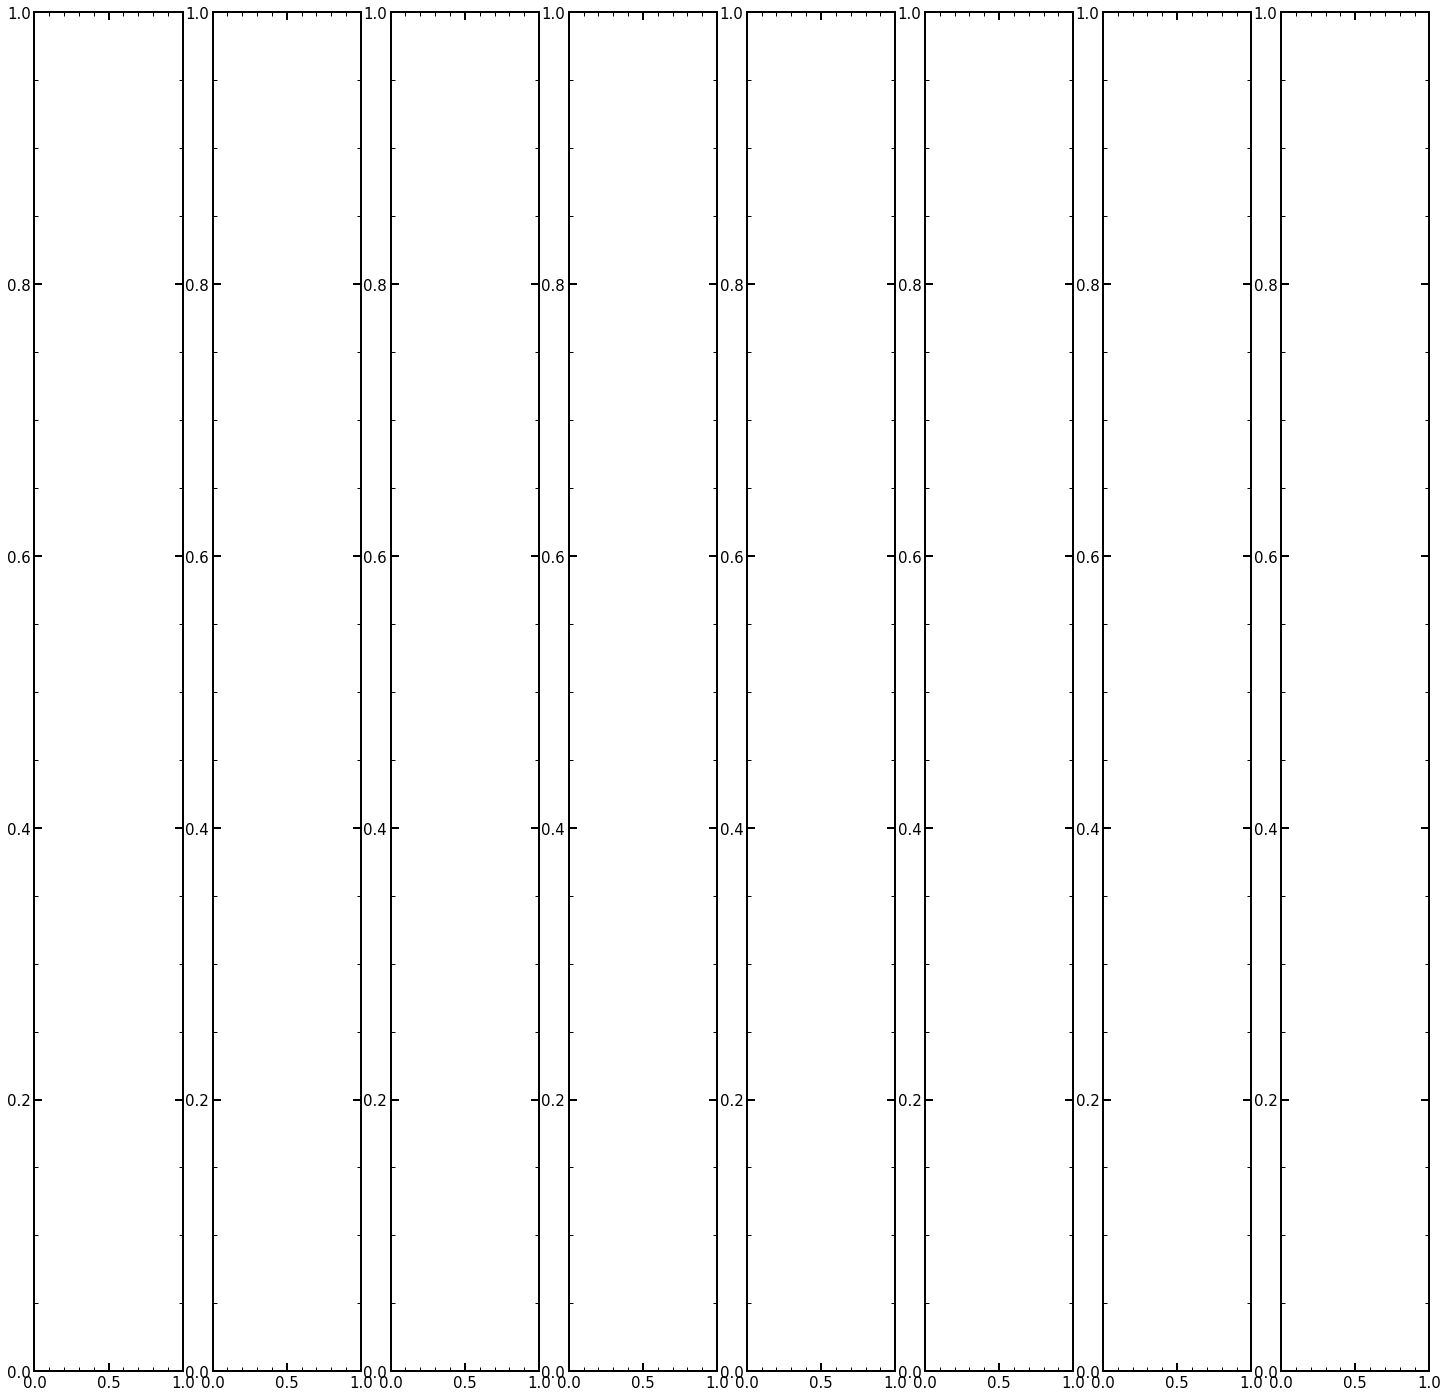

In [16]:
## Visualizar eventos rectos en una sola fila

fig, axs = plt.subplots(ncols = len(Straight_Events), nrows=1, figsize=(25,25))
for index_event in range(0,len(Straight_Events)):
    loc = prop[Straight_Events[index_event]].slice
    mask_35 = np.invert(label_img==n_label)
    data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    # plt.imshow(dataCal[maxim.start:maxim.stop])
    # ax.imshow(data_mask)

    axs.imshow(label_img == Straight_Events[index_event])
    axs.set_title('Event Number: '+ str(Straight_Events[index_event]))
    # axs[0, index_event].axis((loc[1].start-ext, loc[1].stop+ext, loc[0].start-ext, loc[0].stop+ext))


# plt.imshow(label_img==Straight_Events[10])

# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
# round(len(Straight_Events)/2, 0)

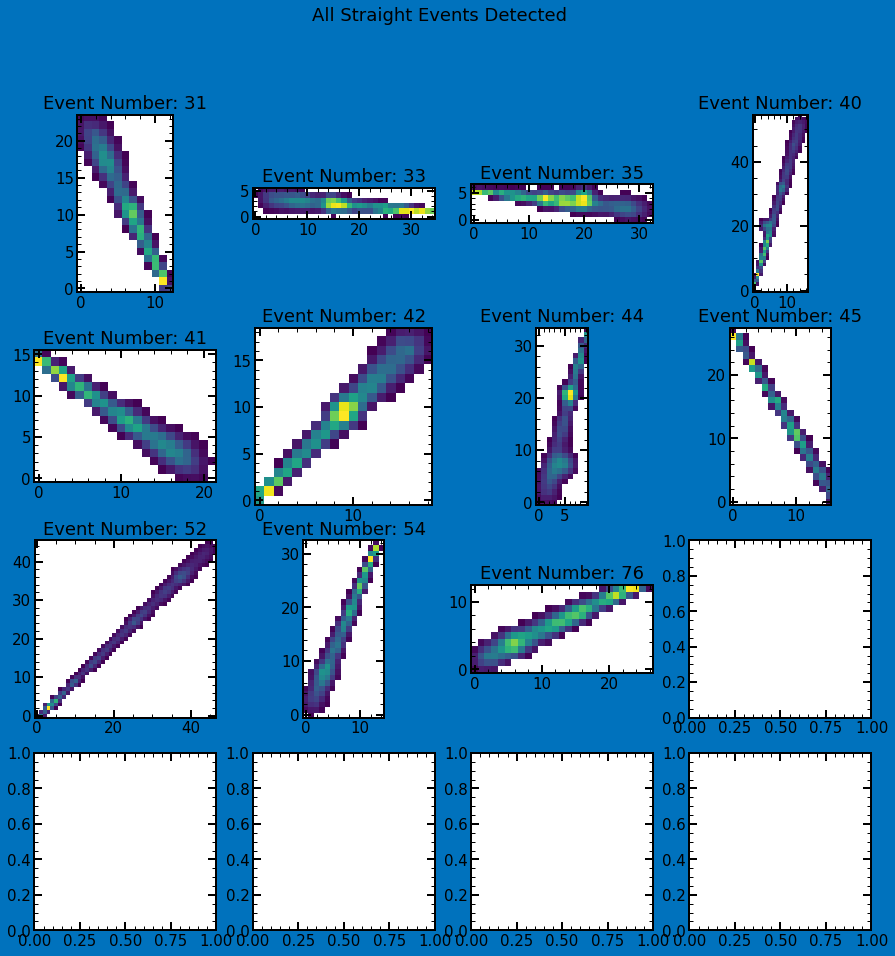

In [101]:
## Visualizar en una matriz los eventos rectos detectados 
coord2x2 = [[0,0],[0,1], [1,0], [1,1]]

coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]

coord4x4 = [[0,0],[0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [1,3], [2,0], [2,1], [2,2], [2,3], [3,0], [3,1], [3,2], [3,3]]

coords5x5 = [[0,0],[0,1], [0,2], [0,3], [0,4], [1,0], [1,1], [1,2], [1,3], [1,4], [2,0], [2,1], [2,2], [2,3], [2,4], [3,0], [3,1], [3,2], [3,3], [3,4],[4,0], [4,1], [4,2], [4,3], [4,4]]

if len(Straight_Events) < 5:
    fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(15,15))
    fig.suptitle('All Muons Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord2x2[index_event][0],coord2x2[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(data_mask) ## Event with mask
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_

elif len(Straight_Events) > 4 and len(Straight_Events) < 10:
    fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord3x3[index_event][0],coord3x3[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(data_mask, aspect = 1) ## Event with mask
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_event, 7][1], 'ro') ## Plot the baricentrum

elif len(Straight_Events) > 9 and len(Straight_Events) < 17:
    fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

        coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
        coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])
        Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]

        axs[coord4x4[index_event][0],coord4x4[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(data_mask, aspect = 1) ## Event with mask
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].text(1,0,'dE/dx', transform = axs[coord4x4[index_event][0],coord4x4[index_event][1]].transAxes)

elif len(Straight_Events) > 16 and len(Straight_Events) < 25:
    fig, axs = plt.subplots(ncols = 5, nrows = 5, figsize=(15,15))
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)        

        axs[coords5x5[index_event][0],coords5x5[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(label_img == Straight_Events[index_event])
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(data_mask) ## Event with mask

elif len(Straight_Events) > 25:
    print('Demasiados eventos para mostrar!!!')



In [103]:
list_nameImage = path.split('_')
list_nameImage[10]

'144'

In [127]:
expgain = [227, 220.4, 94.72, 197.7]
numero_bins = 5000
list_All = []
list_nsamp = []
# list_EventCharge_AllExtensions=[]
list_DeltaEL = []
num_EventosRectos = 0
list_dedl = []
list_diagonal_lenght = []
list_dl = []
list_charge = []
list_angle = []
muons = []
list_extension = []

path_images = ['/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_324_NROW_100_NCOL.fits', \
               '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_225_NROW_100_NCOL.fits', \
                '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_144_NROW_100_NCOL.fits']

for image in path_images:

    list_nameImage = image.split('_')
    hdu_list = fits.open(image)
    for extension in (0,1,3):

        data = hdu_list[extension].data
        header = hdu_list[extension].header
        oScan = hdu_list[extension].data[80:,530:]
        nsamp = float(header['NSAMP'])

        del header

        hist , bins_edges = np.histogram(oScan.flatten(), bins = numero_bins) #'auto'

        del oScan

        offset = bins_edges[np.argmax(hist)]
        dataP = data-offset
        dataCal = (ratio_keV * dataP)/expgain[extension] ## En keV  
        
        del hist
        del data
        del dataP
        
        bin_heights, bin_borders = np.histogram(dataCal.flatten(), bins= numero_bins) #'auto'
        bin_centers=np.zeros(len(bin_heights), dtype=float)
        offset_fit = bin_borders[np.argmax(bin_heights)]
        for p in range(len(bin_heights)):
            bin_centers[p]=(bin_borders[p+1]+bin_borders[p])/2

        xmin_fit, xmax_fit = offset_fit-(10*expgain[extension])/math.sqrt(nsamp), offset_fit+(10*expgain[extension])/math.sqrt(nsamp)			# Define fit range
        bin_heights = bin_heights[(bin_centers>xmin_fit) & (bin_centers<xmax_fit)]
        bin_centers = bin_centers[(bin_centers>xmin_fit) & (bin_centers<xmax_fit)]

        del nsamp

        try:
            popt,_ = curve_fit(gaussian, bin_centers, bin_heights)#, p0=[np.max(bin_heights), 0, 1], maxfev=100000)		# Fit histogram with gaussian

        except:
            continue
        del bin_heights
        del bin_centers
        del offset
        del xmin_fit
        del xmax_fit

        # label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[1,1,1],[1,1,1],[1,1,1]])
        label_img, n_events = sk.measure.label(dataCal > abs(3 *popt[2]), connectivity=2, return_num=True)
        prop = sk.measure.regionprops(label_img, dataCal)
        # list_totalEvents.append(n_events)
        # print(nlabels_img)
        # list_labels.append(label_img)
        # list_EventsNumber.append(n_events)
        
        ## Obteniendo el valor promedio del fondo
        fondo_mask = np.invert(label_img == 0)
        fondo = ma.masked_array(dataCal,fondo_mask)
        valor_promedio_fondo = fondo.data.mean()

        for event in range(1,n_events):
            mask = np.invert(label_img == event)
            loc = ndimage.find_objects(label_img == event)[0]
            data_maskEvent = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop],
                                        mask[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
            
            # del dataCal

            coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
            coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])

            MeanValue_Event = data_maskEvent.mean()
            MinValue_Event = data_maskEvent.min()

            Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]

            try:
                differval = abs(Barycentercharge - MinValue_Event) 
            except:
                differval = 0 

            rM = prop[event-1].axis_major_length
            rm = prop[event-1].axis_minor_length
            Solidity = prop[event-1].solidity

            miny, minx, maxy, maxx = prop[event-1].bbox
            Longitud_y, Longitud_x = maxy - miny , maxx - minx # px
            Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
            Delta_L = np.sqrt( (Diagonal_lenght * px_to_micras)**2 + (CCD_depth)**2) # micras

            if rM == 0 or rm == 0:
                continue 

            elif maxx - minx <= 3:
                continue

            elif not Barycentercharge:
                continue
            
            elif differval < MeanValue_Event + 0.1: #keV
                continue
            
            elif  Solidity < 0.7: ## Ver el artículo: Recognition and classification of the cosmic-ray events in images captured by CMOS/CCD cameras
                continue 

            elif  rM/rm > 4.5: ## Eventos Rectos
                charge = data_maskEvent.sum()
                DeltaEL = (charge /1000) / (Delta_L * micra_to_cm) # MeV/cm
                theta = np.arctan((Diagonal_lenght * px_to_cm)/(CCD_depth * micra_to_cm)) *(180 /np.pi)

                
                muons.append(event - 1)
                list_extension.append(extension +1 )
                list_nsamp.append(list_nameImage[10])
                list_diagonal_lenght.append(Diagonal_lenght * px_to_cm)
                list_dl.append(Delta_L * micra_to_cm)
                list_charge.append(charge)
                list_dedl.append(DeltaEL)
                list_angle.append(theta)

                if DeltaEL_range_min < DeltaEL < DeltaEL_range_max:
                    num_EventosRectos = num_EventosRectos + 1
                    # list_EventCharge_AllExtensions.append(charge)

            del data_maskEvent
            del Barycentercharge


DF_straightevents = pd.DataFrame(muons, columns=['Event ID'] )
DF_nsamp = pd.DataFrame(list_nsamp, columns=['Nsamp'])
DF_extension = pd.DataFrame(list_extension, columns=['Extension'])
DF_diagonal_lenght = pd.DataFrame(list_diagonal_lenght, columns=['Diagonal XY (cm)'])
DF_dl = pd.DataFrame(list_dl, columns=['Delta L (cm)'])
DF_charge = pd.DataFrame(list_charge, columns=['Charge (MeV)'])
DF_dedl = pd.DataFrame(list_dedl, columns=['dE/dL (MeV/cm)'])
DF_angle = pd.DataFrame(list_angle, columns=['Angle (°)'])
DF_dEdL = pd.concat([DF_straightevents, DF_nsamp, DF_extension,   DF_diagonal_lenght, DF_dl, DF_charge,  DF_dedl, DF_angle], axis=1)
DF_dEdL.set_index('Event ID')

,Nsamp,Extension,Diagonal XY (cm),Delta L (cm),Charge (MeV),dE/dL (MeV/cm),Angle (°)
Event ID,,,,,,,
427,144,4,0.064776,0.097222,113.030708,1.1626,41.779575
